In [1]:
import os
import random
import matplotlib.pyplot as plt
from PIL import Image
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from sklearn.model_selection import train_test_split
from tqdm import tqdm

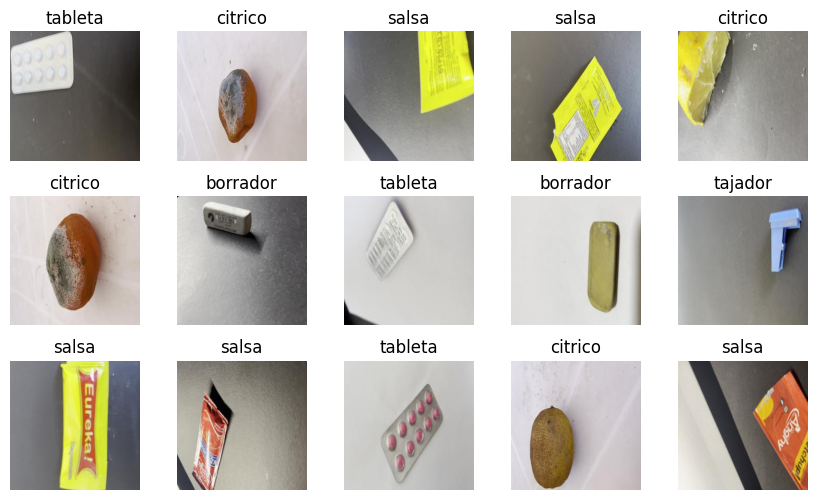

In [2]:
data_path = r"D:\dataset\data_residuos"
classes = os.listdir(data_path)
num_classes = len(classes)

r, c = 3, 5
plt.figure(figsize=(c*1.7, r*1.7))
for row in range(r):
    for col in range(c):
        class_name = random.choice(classes)
        class_path = os.path.join(data_path, class_name)
        img_name = random.choice(os.listdir(class_path))
        img_path = os.path.join(class_path, img_name)
        img = Image.open(img_path)

        plt.subplot(r, c, row * c + col + 1)
        plt.imshow(img)
        plt.axis('off')
        plt.title(class_name)
plt.tight_layout()
plt.show()

In [3]:
# transformaciones
def get_transforms():
    return transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(
            mean = [0.485, 0.456, 0.406],
            std = [0.229, 0.224, 0.225]
        )
    ])

In [4]:
# dataset personalizado
class ResiduosDataset(Dataset):
    def __init__(self, file_paths, labels, transform=None):
        self.file_paths = file_paths
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.file_paths)
    
    def __getitem__(self, idx):
        img = Image.open(self.file_paths[idx]).convert('RGB')
        if self.transform:
            img = self.transform(img)
        return img, self.labels[idx] 

1. Preparacion de datos:
    - Carga de imagenes y etiquetado
    - Division 60 train, 20 val, 20 test
    - Transformaciones con valores de ImageNet

In [5]:
# cargar y dividir datos
def load_and_split_data(data_path, max_images=None, test_size=0.2, val_size=0.2):
    classes = os.listdir(data_path)
    file_paths = []
    labels = []
    # cargar rutas de imagenes y sus etiquetas
    for class_idx, class_name in enumerate(classes):
        class_dir = os.path.join(data_path, class_name)
        class_images = os.listdir(class_dir)
        
        if max_images:
            class_images = class_images[:max_images // len(classes)]
        
        for img_name in class_images:
            file_paths.append(os.path.join(class_dir, img_name))
            labels.append(class_idx)
    # dividir en train_val y test
    train_val_paths, test_paths, train_val_labels, test_labels = train_test_split(
        file_paths, labels, test_size=test_size, random_state=42, stratify=labels
    ) 
    # dividir train y val
    train_paths, val_paths, train_labels, val_labels = train_test_split(
        train_val_paths, train_val_labels, test_size=val_size/(1-test_size),
        random_state=42, stratify=train_val_labels
    )

    return train_paths, val_paths, test_paths, train_labels, val_labels, test_labels, classes

2. Arquitectura del Modelo CNN
    - Capas Convolucionales (extraccion de caracteristicas)
    - Capa fullyConnected (clasificacion)

In [ ]:
# construir el modelo
class CNN(nn.Module):
    def __init__(self, num_classes):
        super(CNN, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, padding=1), # 16 filtros
            nn.ReLU(),
            nn.MaxPool2d(2), # reduce tamaño a la mitad
            nn.Conv2d(16, 32, kernel_size=3, padding=1), # 32 filtros
            nn.ReLU(),
            nn.MaxPool2d(2),
        )
        self.classifier = nn.Sequential(
            nn.Flatten(), # convertir la salida de capas convolucionales (tensores 3D o 4D) en vectores 1D
            nn.Linear(32 * 64 * 64, 256), # capa oculta
            nn.ReLU(),
            nn.Dropout(0.3), # regularizacion
            nn.Linear(256, num_classes) # dalida final
        )
    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x
    
    '''Flujo de Datos:
        - Input: 3x256x256
        - cnv1: 16 filtros -> ReLU -> Maxpool (128x128)
        - cnv2: 32 filtros -> ReLU -> Maxpool (64x64)
        - flatten: 32x64x64 = 131.072 caracteristicas
        - fully connected: 131.072 -> 256 -> num_classes 
    '''

3. Flujo de Entrenamiento por época:
por cada época se ejecuta:
    - Fase de entrenamiento
    - Fase de validacion

In [7]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# funcion de entrenamiento
def train_model(model, dataloaders, criterion, optimizer, num_epochs, patience, scheduler=None):
    model = model.to(device)
    best_acc = 0.0
    no_improve = 0
    history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}

    for epoch in range(num_epochs):
        print(f'epoch {epoch+1}/{num_epochs}')

        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0

            for inputs, labels in tqdm(dataloaders[phase], desc=f'{phase}'):
                inputs, labels = inputs.to(device), labels.to(device)

                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    if phase == 'train':
                        loss.backward() # calculo de gradientes
                        optimizer.step() # actualiza pesos de red
                
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            # promedio por epoca
            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)
            print(f'{phase} loss: {epoch_loss:.4f} acc: {epoch_acc:.4f}')
            # guardar historial
            if phase == 'train':
                history['train_loss'].append(epoch_loss)
                history['train_acc'].append(epoch_acc.item())
            else:
                history['val_loss'].append(epoch_loss)
                history['val_acc'].append(epoch_acc.item())
                #early stopping
                if epoch_acc > best_acc:
                    best_acc = epoch_acc
                    no_improve = 0
                    torch.save(model.state_dict(), 'best_model.pth')
                else:
                    no_improve += 1
        if no_improve >= patience:
            print(f'early stopping en epoch {epoch+1}')
            break
        
    model.load_state_dict(torch.load('best_model.pth'))
    return model, history

In [8]:
# funcion de evaluacion
def evaluate_model(model, dataloader):
    model = model.to(device)
    model.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in tqdm(dataloader, desc='testing'):
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

    accuracy = correct / total
    print(f'test accuracy: {accuracy:.4f}')
    return accuracy

In [9]:
train_paths, val_paths, test_paths, train_labels, val_labels, test_labels, classes = load_and_split_data(
    data_path, max_images=10000, test_size=0.2, val_size=0.2
)

# crear dataset y dataloaders
transform = get_transforms()
train_dataset = ResiduosDataset(train_paths, train_labels, transform)
val_dataset = ResiduosDataset(val_paths, val_labels, transform)
test_dataset = ResiduosDataset(test_paths, test_labels, transform)

dataloaders = {
    'train': DataLoader(train_dataset, batch_size=64, shuffle=True),
        'val': DataLoader(val_dataset, batch_size=64, shuffle=False),
        'test': DataLoader(test_dataset, batch_size=64, shuffle=False)
}

4. Mecanismos de control:
    - early stopping (patience 9)
    - regularizacion:
        - dropout(0.3)
        - weight decay (1e-4)
        - label smoothing (0.1)
5. Optimizacion:
    - Optimizer: Adam 
    - funcion de perdida: CrossEntropyLoss
    - Batch size = 64

In [ ]:
# crear modelo
model = CNN(num_classes = len(classes))
criterion = nn.CrossEntropyLoss(label_smoothing=0.1) # suavizar etiquetas para mejorar generalizacion
optimizer = optim.Adam(model.parameters(), lr=0.0005, weight_decay=1e-4 )

# entrenar
model, history = train_model(
    model, dataloaders, criterion, optimizer, num_epochs=10, patience=9
)
# evaluar con datos de test que no vio
test_accuracy = evaluate_model(model, dataloaders['test'])

epoch 1/10


train: 100%|██████████| 94/94 [03:31<00:00,  2.25s/it]


train loss: 1.5316 acc: 0.5620


val: 100%|██████████| 32/32 [00:59<00:00,  1.86s/it]


val loss: 0.9144 acc: 0.7640
epoch 2/10


train: 100%|██████████| 94/94 [00:28<00:00,  3.34it/s]


train loss: 0.8617 acc: 0.7763


val: 100%|██████████| 32/32 [00:07<00:00,  4.57it/s]


val loss: 0.7690 acc: 0.8355
epoch 3/10


train: 100%|██████████| 94/94 [00:27<00:00,  3.42it/s]


train loss: 0.7393 acc: 0.8545


val: 100%|██████████| 32/32 [00:07<00:00,  4.51it/s]


val loss: 0.7214 acc: 0.8530
epoch 4/10


train: 100%|██████████| 94/94 [00:27<00:00,  3.39it/s]


train loss: 0.6543 acc: 0.9070


val: 100%|██████████| 32/32 [00:06<00:00,  4.69it/s]


val loss: 0.6707 acc: 0.8760
epoch 5/10


train: 100%|██████████| 94/94 [00:27<00:00,  3.41it/s]


train loss: 0.5998 acc: 0.9322


val: 100%|██████████| 32/32 [00:06<00:00,  4.62it/s]


val loss: 0.6396 acc: 0.8995
epoch 6/10


train: 100%|██████████| 94/94 [00:27<00:00,  3.45it/s]


train loss: 0.5642 acc: 0.9495


val: 100%|██████████| 32/32 [00:07<00:00,  4.50it/s]


val loss: 0.6298 acc: 0.9075
epoch 7/10


train: 100%|██████████| 94/94 [00:27<00:00,  3.47it/s]


train loss: 0.5328 acc: 0.9688


val: 100%|██████████| 32/32 [00:06<00:00,  5.13it/s]


val loss: 0.6323 acc: 0.9060
epoch 8/10


train: 100%|██████████| 94/94 [00:26<00:00,  3.59it/s]


train loss: 0.5157 acc: 0.9765


val: 100%|██████████| 32/32 [00:06<00:00,  5.11it/s]


val loss: 0.6078 acc: 0.9080
epoch 9/10


train: 100%|██████████| 94/94 [00:26<00:00,  3.56it/s]


train loss: 0.4952 acc: 0.9872


val: 100%|██████████| 32/32 [00:06<00:00,  5.14it/s]


val loss: 0.6080 acc: 0.9155
epoch 10/10


train: 100%|██████████| 94/94 [00:26<00:00,  3.55it/s]


train loss: 0.4828 acc: 0.9937


val: 100%|██████████| 32/32 [00:06<00:00,  5.17it/s]


val loss: 0.5936 acc: 0.9245


testing: 100%|██████████| 32/32 [00:51<00:00,  1.62s/it]

test accuracy: 0.9145


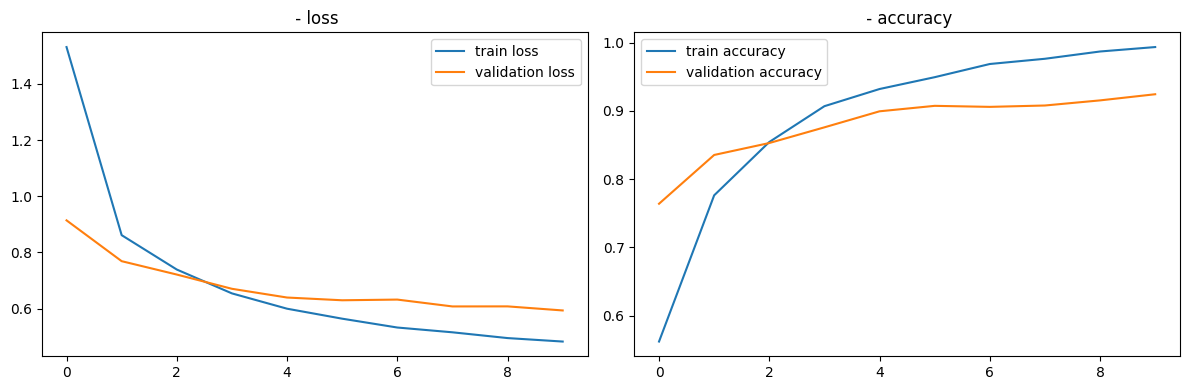

In [11]:
def plot_results(history, title=''):
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    plt.plot(history['train_loss'], label='train loss')
    plt.plot(history['val_loss'], label='validation loss')
    plt.legend()
    plt.title(f'{title} - loss')

    plt.subplot(1, 2, 2)
    plt.plot(history['train_acc'], label='train accuracy')
    plt.plot(history['val_acc'], label='validation accuracy')
    plt.legend()
    plt.title(f'{title} - accuracy')
    plt.tight_layout()
    plt.show()

plot_results(history)

Grafica de loss:
    - train loss: desciende consistentemente hasta 0.6
    - validation loss: tambien desciende pero con algunas fluctuaciones
    Ambas curvas descienden juntas, indicando que el modelo esta aprendiendo sin overfitting.

Gafica accuracy:
    - train acc: alcanza un 85% aprox.
    - validation acc: alcanza al rededor de 80%.
    La brecha es de 5% lo que indica buen balance.

Recomendaciones:
    - Agregar mas capas conv a la arquitectura del modelo.
    - Aumentar dropout y data augmentation.
    - Agregar learning rate scheduler.

PIPELINE: Datos -> transformaciones -> Dataloader -> Forward Pass -> Calcular perdida -> Backward Pass -> Actualizar pesos -> validar -> early stopping -> evaluar con datos de test.

Entrenando con modelo preentrenado NFNet (ECA-NFNetL0 2021)
- Caracteristicas:
- Normalizer-Free: Elimina la necesidad de Batch Normalization
- Weight Standardization: Tecnica de normalizacion de pesos
- Adaptive Gradient Clipping: Control inteligente de gradientes
- Efficient Channel Attention (ECA): Mecanismo de atencion ligero

Arquitectura:
Input -> Stem (caracteristicas simples) -> stage 1 (carac. intermedias) -> stage 2 (caract. complejas) -> stage 3 (caract. especificas) -> head (clasifiacion)

In [12]:
import timm
from timm.data import resolve_data_config, create_transform

d:\inteligencia_artificial\test\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


1. Cargar NFNet preentrenado congelado 
2. Reemplazar cabeza de clasificacion

In [ ]:
# configurar modelo NFNet
def setup_nfnet(num_classes):
    model = timm.create_model('eca_nfnet_l0', pretrained=True, num_classes=num_classes)
    # modelo preentrenado congelado
    for param in model.parameters():
        param.requires_grad = False # todas las capas congeladas

    # solo la nueva cabeza es entrenable
    in_features = model.head.fc.in_features
    model.head.fc = nn.Sequential(
        nn.Linear(in_features, 128), # nueva capa
        nn.ReLU(),
        nn.Dropout(0.3),
        nn.Linear(128, num_classes) # clasificacion final
    )
    return model

# obtener transformaciones para NFNet
def get_nfnet_transform(model):
    config = resolve_data_config({}, model=model)
    return create_transform(**config)

# preparar modelo para fine-tuning
def prepare_for_fine_tuning(model):
    for name, param in model.named_parameters():
        # descogelar ultima etapa convolucional
        if 'stage.3' in name or 'head' in name:
            param.requires_grad = True
    return model

In [14]:
model_nfnet = setup_nfnet(num_classes=len(classes))
nfnet_transform = get_nfnet_transform(model_nfnet)

In [15]:
# crear dataset y dataloader para NFNet
train_dataset_nfnet = ResiduosDataset(train_paths, train_labels, nfnet_transform)
val_dataset_nfnet = ResiduosDataset(val_paths, val_labels, nfnet_transform)
test_dataset_nfnet = ResiduosDataset(test_paths, test_labels, nfnet_transform)

dataloaders_nfnet = {
    'train': DataLoader(train_dataset_nfnet, batch_size=64, shuffle=True),
    'val': DataLoader(val_dataset_nfnet, batch_size=64, shuffle=False),
    'test': DataLoader(test_dataset_nfnet, batch_size=64, shuffle=False)
}

3. FASE 1: Entrenar solo cabeza (5 epocas)

In [16]:
# entrenar solo la cabeza de clasificacion
optimizer_nfnet_head = optim.AdamW(
    [{'params': model_nfnet.head.fc.parameters(), 'lr': 0.001}],
    weight_decay=1e-4
)

model_nfnet, history_nfnet_head = train_model(
    model_nfnet, dataloaders_nfnet, criterion, optimizer_nfnet_head, num_epochs=5, patience=3
)

epoch 1/5


train: 100%|██████████| 94/94 [01:18<00:00,  1.20it/s]


train loss: 0.5233 acc: 0.9712


val: 100%|██████████| 32/32 [00:25<00:00,  1.24it/s]


val loss: 0.4207 acc: 0.9960
epoch 2/5


train: 100%|██████████| 94/94 [01:16<00:00,  1.24it/s]


train loss: 0.4189 acc: 0.9983


val: 100%|██████████| 32/32 [00:25<00:00,  1.25it/s]


val loss: 0.4104 acc: 0.9975
epoch 3/5


train: 100%|██████████| 94/94 [01:17<00:00,  1.22it/s]


train loss: 0.4111 acc: 0.9997


val: 100%|██████████| 32/32 [00:24<00:00,  1.29it/s]


val loss: 0.4062 acc: 0.9980
epoch 4/5


train: 100%|██████████| 94/94 [01:14<00:00,  1.25it/s]


train loss: 0.4080 acc: 1.0000


val: 100%|██████████| 32/32 [00:24<00:00,  1.29it/s]


val loss: 0.4056 acc: 0.9975
epoch 5/5


train: 100%|██████████| 94/94 [01:14<00:00,  1.26it/s]


train loss: 0.4058 acc: 1.0000


val: 100%|██████████| 32/32 [00:24<00:00,  1.33it/s]

val loss: 0.4039 acc: 0.9975


4. Descongelar stage 3 + head
5. FASE 2: Fine-tunning parcial (10 epocas)

In [ ]:
# fine-tuning
model_nfnet = prepare_for_fine_tuning(model_nfnet)
optimizer_ft = optim.AdamW([
    {'params': model_nfnet.stages[3].parameters(), 'lr':0.0001},
    {'params': model_nfnet.head.parameters(), 'lr':0.0001}
], weight_decay=1e-4)

# reducir lr progresivamente
scheduler = optim.lr_scheduler.StepLR(optimizer_ft, step_size=5, gamma=0.1)

# entrenar
model_nfnet, history_nfnet_ft = train_model(
    model_nfnet, dataloaders_nfnet, criterion, optimizer_ft, num_epochs=10, patience=5, scheduler=scheduler
)

epoch 1/10


train: 100%|██████████| 94/94 [01:12<00:00,  1.29it/s]


train loss: 0.4074 acc: 0.9998


val: 100%|██████████| 32/32 [00:23<00:00,  1.35it/s]


val loss: 0.4047 acc: 0.9985
epoch 2/10


train: 100%|██████████| 94/94 [01:10<00:00,  1.33it/s]


train loss: 0.4064 acc: 1.0000


val: 100%|██████████| 32/32 [00:23<00:00,  1.35it/s]


val loss: 0.4043 acc: 0.9985
epoch 3/10


train: 100%|██████████| 94/94 [01:10<00:00,  1.33it/s]


train loss: 0.4056 acc: 1.0000


val: 100%|██████████| 32/32 [00:23<00:00,  1.36it/s]


val loss: 0.4039 acc: 0.9985
epoch 4/10


train: 100%|██████████| 94/94 [01:10<00:00,  1.34it/s]


train loss: 0.4050 acc: 1.0000


val: 100%|██████████| 32/32 [00:23<00:00,  1.35it/s]


val loss: 0.4033 acc: 0.9985
epoch 5/10


train: 100%|██████████| 94/94 [01:10<00:00,  1.33it/s]


train loss: 0.4048 acc: 1.0000


val: 100%|██████████| 32/32 [00:23<00:00,  1.36it/s]


val loss: 0.4030 acc: 0.9985
epoch 6/10


train: 100%|██████████| 94/94 [01:10<00:00,  1.33it/s]


train loss: 0.4044 acc: 1.0000


val: 100%|██████████| 32/32 [00:23<00:00,  1.35it/s]


val loss: 0.4028 acc: 0.9985
early stopping en epoch 6


6. Evalucaion final

testing: 100%|██████████| 32/32 [00:23<00:00,  1.36it/s]


test accuracy: 0.9990
Convolucional simple-test accuracy: 0.9145
Modelo NFNet-test accuracy: 0.9990


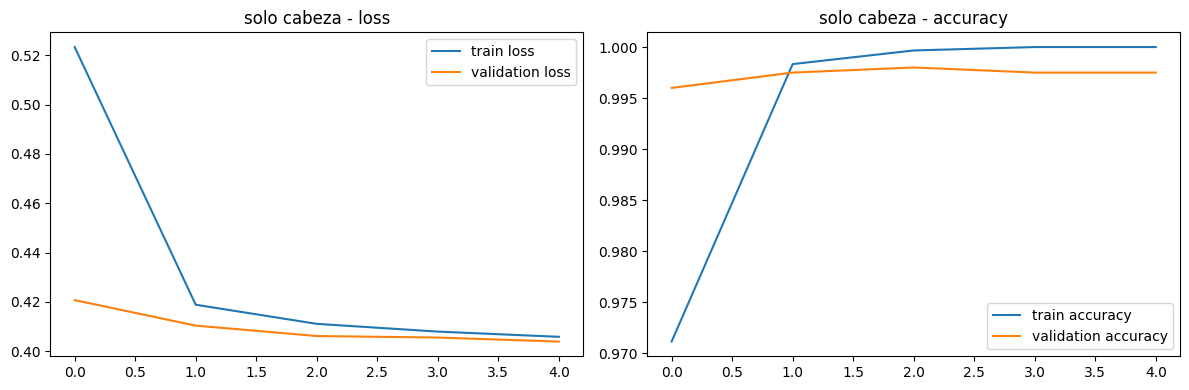

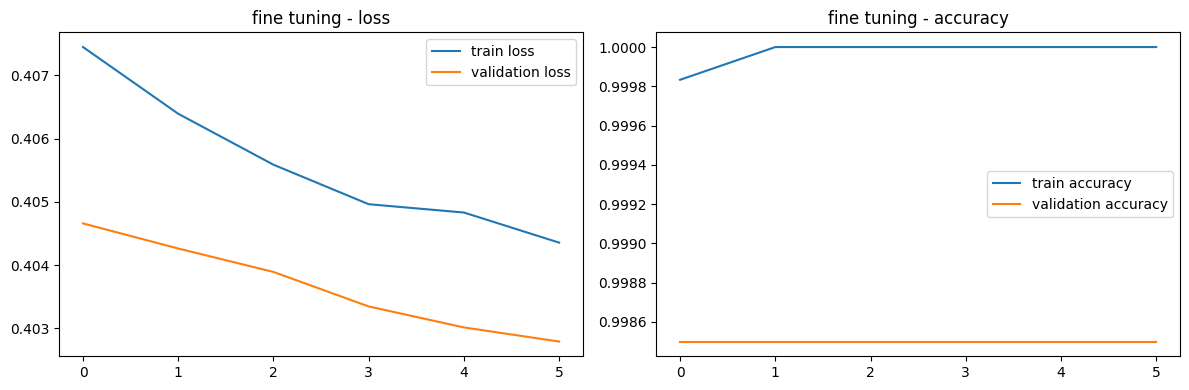

In [19]:
# evaluar
test_accuracy_nfnet = evaluate_model(model_nfnet, dataloaders_nfnet['test'])

print(f'Convolucional simple-test accuracy: {test_accuracy:.4f}')
print(f'Modelo NFNet-test accuracy: {test_accuracy_nfnet:.4f}')

plot_results(history_nfnet_head, 'solo cabeza') 
plot_results(history_nfnet_ft, 'fine tuning') 

Graficas de entrenamiento Inferidas:
- Fase1 - Solo Cabeza:
    - rapida convergencia: la cabeza se adapto rapido a mis datos.
    - loss descendente: ambas curvas (train/val) bajando juntas
- Fase2 - Fine tuning:
    - overfitting minimo: brecha entre train/val
    - estabilidad: curvas suaves sin fluctuaciones bruscas
    - covergencia rapida: probablemente en pocas epocas.

RESULTADOS FINALES:
CNN Desde cero: 91.45%
NFNet preentrenado: 99.90% mejora (+8.45%) 

In [ ]:
def mostrar_predicciones(model, dataloader, classes, num_imagenes=12):
    model.eval()
    model.to(device)
    
    # batch de datos
    dataiter = iter(dataloader)
    images, labels = next(dataiter)
    images, labels = images.to(device), labels.to(device)

    # predecir
    with torch.no_grad():
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
    images = images.cpu()
    labels = labels.cpu()
    preds = preds.cpu()
    
    fig, axes = plt.subplots(3, 4, figsize=(15, 10))
    axes = axes.ravel()
    
    for i in range(num_imagenes):
        # desnormalizar imagen
        img = images[i].numpy().transpose((1, 2, 0))
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        img = std * img + mean
        img = np.clip(img, 0, 1)
        
        # mostrar imagenes y etiquetas
        axes[i].imshow(img)
        pred_label = classes[preds[i]]
        true_label = classes[labels[i]]
        color = 'green' if pred_label == true_label else 'red'
        
        axes[i].set_title(f'real: {true_label}\npred: {pred_label}')
        axes[i].axis('off')
    
    plt.tight_layout()
    plt.show()

mostrar_predicciones(model_nfnet, dataloaders_nfnet['test'], classes)
mostrar_predicciones(model, dataloaders['test'], classes)